In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

코랩 사용하시는 분들은 아래의 코드를 실행해주세요!

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
os.getcwd()

'/content'

코랩 사용시 본인 구글 드라이브 경로는  
/content/drive/MyDrive/...  
입니다.

In [4]:
path = './drive/MyDrive/DSL'    # 과제 데이터셋이 저장된 경로를 더 작성해주세요
os.chdir(path)

In [5]:
os.getcwd()

'/content/drive/MyDrive/DSL'

사용할 데이터 셋 :  전력 사용량 예측 모델

아래의 과정에서 sklearn의 Pipeline의 사용은 필수는 아닙니다. 선호와 필요에 따라 사용하실 분들은 사용하셔도 좋습니다.

# 데이터

건물 정보와 기후 정보를 활용한 전력사용량 예측 데이터 중에서 

환경 변수(기온, 풍속, 습도, 강수량, 일조)에 대해 전력 사용량을 선형회귀 모델을 사용해서 예측해보고자 합니다.

In [6]:
var_name = ['Temp', 'Wind', 'Moisture', 'Precipitation', 'Sun']
target = 'Wh'

In [7]:
def parsing(data: pd.DataFrame):
    x = data.iloc[:, 3:8]
    x.columns = var_name
    y = data.iloc[:, 2]
    y.name = target
    
    return x, y

In [8]:
def load_data():
    data = pd.read_csv('train.csv', encoding='cp949')
    data = data[: 100]
    x, y = parsing(data)    
    cut = int(round(len(x)*0.88))
    tr_x = x[:cut]
    tr_y = y[:cut]
    te_x = x[cut:]
    te_y = y[cut:]
    return tr_x, tr_y, te_x, te_y

In [42]:
train_x, train_y, test_x, test_y = load_data()

## 데이터 확인 

주의! 최종 예측하는 단계 이전에는 현재 가지고 있는 데이터, 즉 train data만을 이용하여 작업을 진행해야 합니다.

현재 가지고 있는 데이터 train_x를 보고 전력 사용량을 예측하는데에 사용할 변수를 선택해주세요.

기초세션에서 다뤘던 내용을 참고하셔서 최적의 변수 조합을 찾아보도록 합시다.

이 때 선택해야하는 변수는 하나일 수도 있고, 여러개의 변수를 사용하여도 좋습니다.

In [10]:
train_x.describe()

,Temp,Wind,Moisture,Precipitation,Sun
count,88.000000,88.000000,88.000000,88.000000,88.000000
mean,20.243182,2.630682,71.022727,0.038636,0.290909
std,3.284229,1.082712,15.966903,0.220986,0.415404
min,14.800000,0.400000,39.000000,0.000000,0.000000
25%,17.600000,2.000000,59.500000,0.000000,0.000000
50%,20.100000,2.500000,74.500000,0.000000,0.000000
75%,22.175000,3.200000,84.500000,0.000000,0.625000
max,28.200000,5.500000,93.000000,1.900000,1.000000


In [11]:
train_y.describe()

count      88.000000
mean     8142.186273
std       203.650160
min      7784.424000
25%      8013.006000
50%      8093.196000
75%      8264.430000
max      8663.112000
Name: Wh, dtype: float64

In [12]:
# 데이터 셋을 둘러보는 코드 작성하시고, 왜 좋은지 한번 둘러보세요!
train_x = train_x
train_x.head()

,Temp,Wind,Moisture,Precipitation,Sun
0,17.6,2.5,92.0,0.8,0.0
1,17.7,2.9,91.0,0.3,0.0
2,17.5,3.2,91.0,0.0,0.0
3,17.1,3.2,91.0,0.0,0.0
4,17.0,3.3,92.0,0.0,0.0


Text(0.5, 1.0, 'Sun')

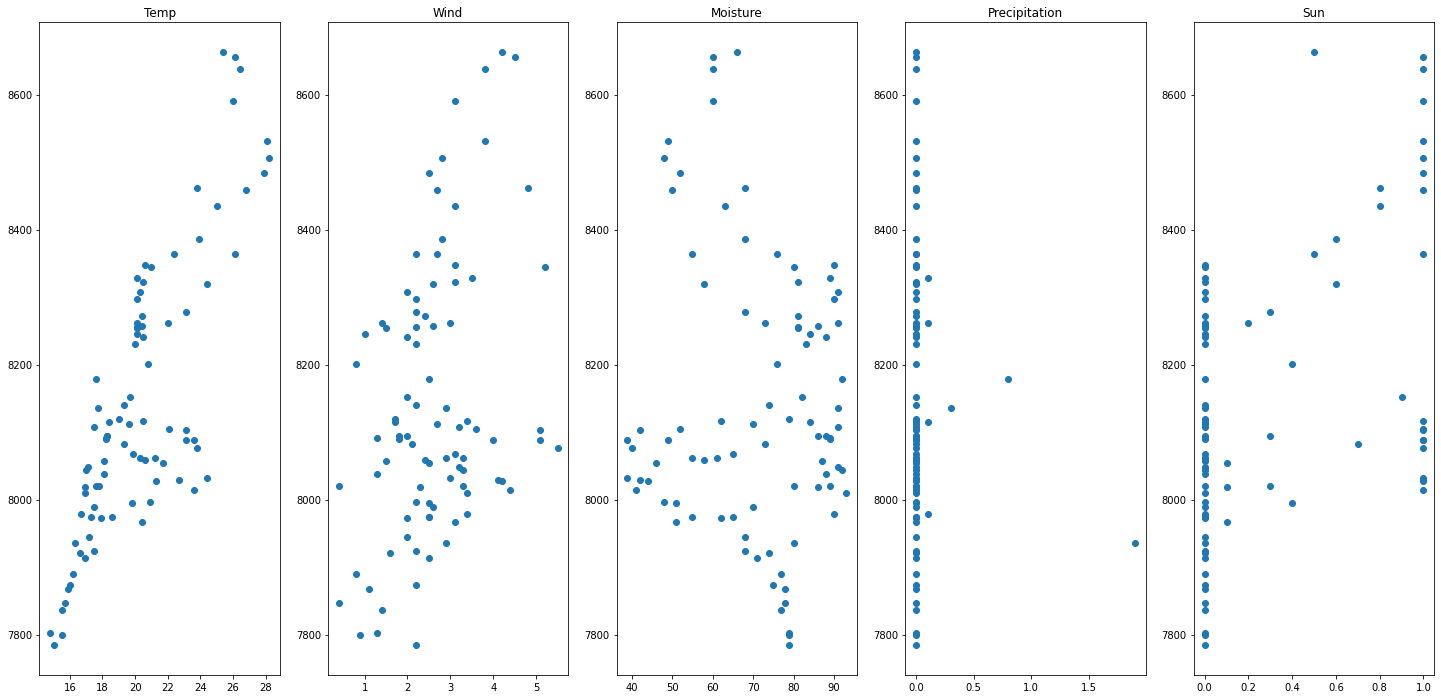

In [13]:
plt.figure(figsize=(25,12))
plt.subplot(1,5,1)
plt.scatter(train_x['Temp'], train_y)
plt.title("Temp")

plt.subplot(1,5,2)
plt.scatter(train_x['Wind'],train_y)
plt.title("Wind")

plt.subplot(1,5,3)
plt.scatter(train_x['Moisture'],train_y)
plt.title("Moisture")

plt.subplot(1,5,4)
plt.scatter(train_x['Precipitation'],train_y)
plt.title("Precipitation")

plt.subplot(1,5,5)
plt.scatter(train_x['Sun'],train_y)
plt.title("Sun")

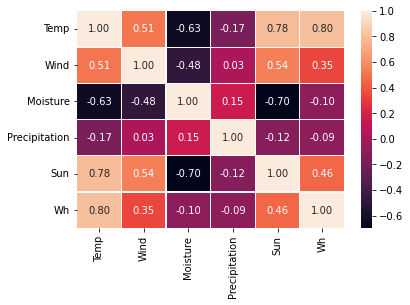

In [43]:
train = pd.concat([train_x, train_y], axis=1)
sns.heatmap(train.corr(), fmt='.2f', annot=True, linewidths=0.2)

In [15]:
train_x = pd.DataFrame(train_x['Temp'])
train_x

,Temp
0,17.6
1,17.7
2,17.5
3,17.1
4,17.0
...,...
83,23.9
84,25.0
85,26.0
86,26.4


In [16]:
train_x.shape

(88, 1)

정답은 없습니다! 

다만 최종 선택한 변수(들)이 왜 선택받았는지 간단히 알려주세요.<br>
답변 : 변수들이 전력 사용량과 일정한 상관관계를 가지고 있어야 하기 때문에 변수 간의 상관관계를 heatmap과 scatter plot을 통해 확인했다. Temp, Wind, Sun을 변수로 선택하고자 했으나, Temp와 Wind, Temp와 Sun의 상관계수 값이 y값과의 상관계수 값보다 크기 때문에 x 변수로 Temp만 선택했다.

## 전처리

위에서 선택한 변수들(feature)를 가지고 한번 전력 사용량을 예측하는 모델을 만들어 보기에 앞서,

**train 데이터의 feature의 전처리**를 진행해보려고 합니다. StandardScaler를 사용하셔도 좋고, MinMaxScaler를 사용하셔도 좋습니다! 

또한 PolynomialFeatures를 이용하거나 직접 feature를 계산하여 고차원의 feature를 만드셔도 좋습니다. 이 또한 정답은 없습니다!

이 때 최종 train_x의 shape은 (n_samples, n_features)가 되도록 해주세요.<br>
ex. 4개의 변수를 가진 1000개의 샘플의 경우 train_x.shape은 (1000,4)가 되면 됩니다.

특히 하나의 변수만을 사용하시는 분들은 1D가 아닌 2D가 되도록 신경써주세요<br>
ex. train_x.shape이 (1000,)이 아닌 (1000,1)입니다!

In [17]:
# 사용할 패키지를 import!
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()
scaler = scaler.fit(train_x)
train_x_sc = scaler.transform(train_x)
train_x_sc.shape

(88, 1)

# 모델링

## 학습 

이제 모델링을 해봅시다.

앞서 다룬 여러 regression 모델들(Linear regression, Ridge Regression, Lasso Regression, ..)을 이용해서 fit을 진행해보도록 합시다.

In [19]:
# 사용할 패키지를 import!
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso

In [20]:
# Linear Regression
linear_model = LinearRegression().fit(train_x_sc, train_y)

In [21]:
# Ridge Regression
ridge_model = Ridge(random_state=123).fit(train_x_sc, train_y)

In [22]:
lasso_model = Ridge(random_state=123).fit(train_x_sc, train_y)

## 추정

이제 train_x를 이용하여 전력사용량을 추정해보도록 합시다.

In [23]:
linear_esti_y = linear_model.predict(train_x_sc)

linear_beta = linear_model.coef_[0]
linear_intercept = linear_model.intercept_
print(f"Beta :{linear_beta}")
print(f"Intercept : {linear_intercept: .4f}")

Beta :667.4740477071363
Intercept :  7871.0532


In [24]:
ridge_esti_y = ridge_model.predict(train_x_sc)

ridge_beta = ridge_model.coef_[0]
ridge_intercept = ridge_model.intercept_
print(f"Beta :{ridge_beta}")
print(f"Intercept : {ridge_intercept: .4f}")

Beta :560.2679950965702
Intercept :  7914.6012


In [25]:
lasso_esti_y = ridge_model.predict(train_x_sc)

lasso_beta = ridge_model.coef_[0]
lasso_intercept = ridge_model.intercept_
print(f"Beta :{lasso_beta}")
print(f"Intercept : {lasso_intercept: .4f}")

Beta :560.2679950965702
Intercept :  7914.6012


# Loss 및 시각화

앞서 fitting하여 얻은 모델을 이용하여 추정한 값으로 MSE를 측정해봅시다. 변수를 하나만 사용하신 분들은 xy 평면에 한번 같이 시각화도 해보셔도 좋습니다.

In [26]:
def mse(pred, true):
    return np.mean((pred-true)**2)

In [27]:
linear_train_mse = mse(linear_esti_y, train_y)
print(f"Linear MSE : {linear_train_mse:.5f}")

ridge_train_mse = mse(ridge_esti_y, train_y)
print(f"Ridge MSE : {ridge_train_mse:.5f}")

lasso_train_mse = mse(lasso_esti_y, train_y)
print(f"Lasso MSE : {lasso_train_mse:.5f}")

Linear MSE : 14543.75828
Ridge MSE : 15226.30510
Lasso MSE : 15226.30510


In [28]:
def visualize(model, x, y):
    if x.shape[1] != 1:
        return None
    beta = model.coef_[0]
    intercept = model.intercept_
    
    x_axis = np.linspace(np.min(x), np.max(x), 100)
    fit = intercept * x_axis**0 + beta*x_axis 

    plt.figure(figsize=(8,6))
    plt.plot(x_axis, fit, label='Predict', c='r', linewidth=3)
    plt.scatter(x, y, c='blue')
    plt.legend()
    plt.show()

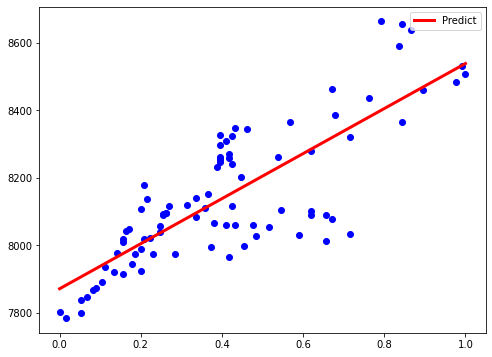

In [29]:
# Linear
visualize(linear_model, train_x_sc, train_y)

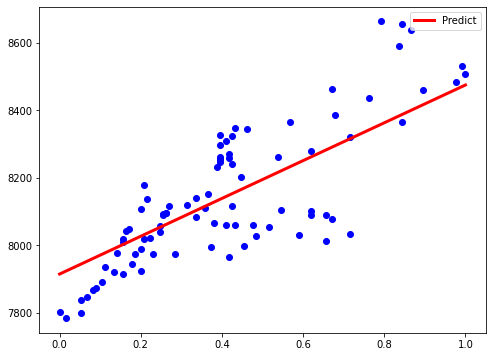

In [30]:
# Ridge
visualize(ridge_model, train_x_sc, train_y)

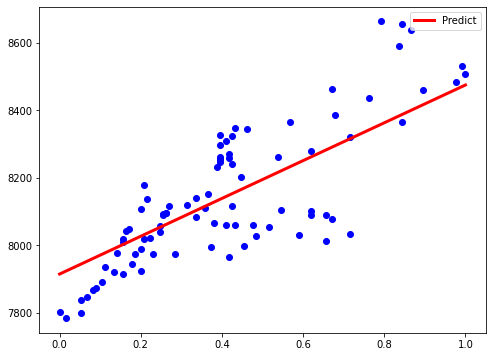

In [31]:
# Lasso
visualize(lasso_model, train_x_sc, train_y)

# 예측

테스트셋에 대해서 한번 **예측**해보도록 합시다.

이미 fitting된 모델 (그리고 scaler를 사용하신다면 scaler)에 대해 **fit을 하지 말고** 단순히 predict만 진행해보도록 합시다. 

scaler는 transform만 하시고 model은 predict을 진행해주세요

In [32]:
# transform을 하시는 분들은 실행해주세요
test_x = pd.DataFrame(test_x['Temp'])
test_x_sc = scaler.transform(test_x)

In [33]:
# y1_hat에 predict값 할당
linear_pred_y = linear_model.predict(test_x_sc)
ridge_pred_y = ridge_model.predict(test_x_sc)
lasso_pred_y = lasso_model.predict(test_x_sc)

# 성능 평가

한번 학습한 모델에 대해 test_y를 이용하여 mse loss를 측정해도도록 합시다.

In [34]:
def score(train_mse, test_mse):
    print(f"{test_mse/train_mse: .4f}")

In [36]:
linear_test_mse = mse(linear_pred_y, test_y)
print(f"Linear MSE : {linear_test_mse: .5f}")

ridge_test_mse = mse(ridge_pred_y, test_y)
print(f"Ridge MSE : {ridge_test_mse: .5f}")

lasso_test_mse = mse(lasso_pred_y, test_y)
print(f"Lasso MSE : {lasso_test_mse: .5f}")

Linear MSE :  198060.52184
Ridge MSE :  202457.35936
Lasso MSE :  202457.35936


In [37]:
score(linear_train_mse, linear_test_mse)
score(ridge_train_mse, ridge_test_mse)
score(lasso_train_mse, lasso_test_mse) 

 13.6182
 13.2966
 13.2966


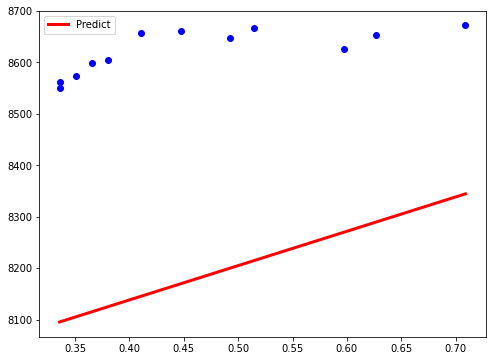

In [38]:
# Linear
visualize(linear_model, test_x_sc, test_y)

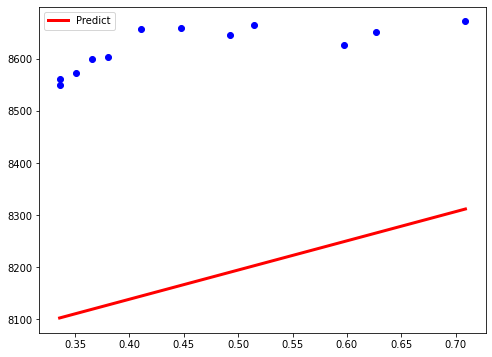

In [39]:
# Ridge
visualize(ridge_model, test_x_sc, test_y)

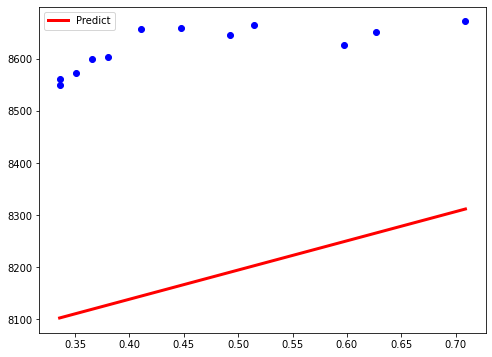

In [40]:
# Lasso
visualize(lasso_model, test_x_sc, test_y)

# 그 이후

이제 여러분들은 한번 모델을 만들어보고 fitting한 다음 예측까지 해보셨습니다.

이제 개선하기 위해 1.데이터부터 5.성능평가 중 수정, 변경하실 부분을 업데이트 해서  최적의 모델을 찾아보세요!

현재 사용하고 있는 scaler, model부터 전처리과정 기타 여러 조건을 조작해보시고 어떤 효과가 있는지 한번 보시고 알려주세요:D

고생하셨습니다!